In [151]:
import numpy as np
import pandas as pd
from itertools import combinations

# Removing A Specified Row and Column from a Matrix

In [152]:
x = np.array([[1,2,3],[4,5,6],[7,8,9]])
print(x)

[[1 2 3]
 [4 5 6]
 [7 8 9]]


In [153]:
# if we want to remove the 2nd row and 2nd column, this works:
y = np.delete(x,1,axis = 0)
y = np.delete(y,1,axis = 1)
print(y)

[[1 3]
 [7 9]]


In [154]:
z = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])
print(z)

[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]]


In [155]:
# if we want to remove both the 2nd and 4th rows and columns, this code works
y = np.delete(z,(1,3),axis = 0)
y = np.delete(y,(1,3),axis = 1)
print(y)

[[ 1  3]
 [ 9 11]]


# Writing a Function to Take A Matrix and Repeatedly Apply this

We want this function to take as an inputs:

- $P_{ij}$, the original stochastic matrix.
- $\alpha$, the teleportation paramter
- $stats1$, a vector containing the winning percentages of the teams of interest
- $namesCols$, the names of the win percentage vectors
- $N$, the number of teams to eliminate at each step (anticipate 1 or 2 will be best)
- $method$, the method for determining $\nu$, set to 0 (for using weights in each node) by default if not specified.


We want this function to output:

- $S$, a matrix of scores where each row is one of the 32 teams, and each column is that teams computed score when ommiting a combination of teams

In [156]:
def score_bagging(Pij, stats1, namesCols, alpha, N, Nsims = 5000, method = 0):
    # setting a vector to contain each of the 32 team numbers
    teamnum = np.arange(32)
    # Getting the possible combinations of this to use
    combs = list(combinations(teamnum, N))
    ncombs = len(combs)
    # initializing a matrix to store each of these values
    scores = np.zeros((len(teamnum),ncombs))
    # We iterate over all of these combinations, each time computing a final score vector
    for counter, group in enumerate(combs):
        # Adjusting Pij (first deleting the specified rows, then columns)
        Pij_group = np.delete(Pij,group,axis = 0)
        Pij_group = np.delete(Pij_group,group,axis = 1)
        
        # Ensuring Pij has no zero columns
        if len(np.where(Pij_group.sum(axis = 0) == 0)[0]) > 0:
                empty_vect = np.where(Pij_group.sum(axis = 0) == 0)[0]
                for iCnt in range(len(empty_vect)):
                    Pij_group[empty_vect[iCnt],empty_vect[iCnt]] = 1
        
        # -----------Getting the Scores (FROM PREVIOUS CODE)------------------------
        # If we want the teleportation probabilties unifrom,
        # or based on team winning perc
        if method == 0:
            # making the teleporting probabilities uniform
            v = np.ones(len(teamnum)-N)/(len(teamnum)-N)
            v = v[np.newaxis]
            v = v.T
            # Setting alpha
            alpha = alpha
            # Setting eT
            eT = np.ones(len(teamnum)-N)[np.newaxis]   
        else:
            # making the teleporting probabilities proportional to
            # the teams winning percentages
            v = np.array(stats1[namesCols])
            v = np.delete(v, group)
            v = v[np.newaxis]
            v = v.T
            v = v/np.sum(v)
            # Setting alpha
            alpha = alpha
            # Setting eT
            eT = np.ones(len(teamnum)-N)[np.newaxis]
                
        # initializing our first guess
        x0 = np.ones(len(teamnum)-N)/len(teamnum)-N
        x0 = x0[np.newaxis]
        x0 = x0.T
            
        # performing the simulation (so our scores are stored in x0)
        for i in range(Nsims):
            x0 = alpha*np.dot(Pij_group,x0) + (1-alpha)*v

        # ---------------------- (END OF PREVIOUS CODE) ------------------------
        # getting a vector of the values of the teams computed
        kept_vect = np.delete(teamnum,group)
        # Updating the matrix
        scores[kept_vect,counter] = np.squeeze(x0)
    return scores    

# Testing the Function

In [230]:
data = pd.read_csv('Pij_2017.csv',index_col=0)
stats2017 = pd.read_csv('2017_win_perc.csv',index_col=0)
namesCols = "win_perc_2017"

In [231]:
# getting Pij
data2 = np.array(data)
Pij = data2/data2.sum(axis=0)

In [251]:
scores = score_bagging(Pij, stats2017, namesCols, .4, N = 1, method = 0)
print(scores)

[[ 0.          0.04459178  0.04851096 ...,  0.0464629   0.04868648
   0.04749478]
 [ 0.02861215  0.          0.02994843 ...,  0.02983281  0.03014898
   0.02946815]
 [ 0.02816158  0.02817317  0.         ...,  0.02796983  0.02758292
   0.02815255]
 ..., 
 [ 0.02308461  0.02355635  0.02380145 ...,  0.          0.02390594
   0.02340536]
 [ 0.02376878  0.02378378  0.02377714 ...,  0.02377272  0.          0.02374149]
 [ 0.02526409  0.02509155  0.02507314 ...,  0.02507405  0.02528657  0.        ]]


In [252]:
# finding where the biggest difference occured
diff_vect = np.zeros(32)
for iCnt in range(32):
    diff_vect[iCnt] = np.max(scores[iCnt,np.nonzero(scores[iCnt,])[0]]) - \
                np.min(scores[iCnt,np.nonzero(scores[iCnt,])[0]])

In [253]:
print(diff_vect)
print(np.argmax(diff_vect))

[ 0.0100398   0.00536359  0.00385521  0.00696024  0.00295629  0.00227872
  0.          0.00379414  0.0011605   0.00647328  0.00596421  0.00220546
  0.00534549  0.00595479  0.00313049  0.00371583  0.0025792   0.01316183
  0.00641119  0.01488263  0.01433315  0.00066695  0.00464351  0.0023757
  0.00372771  0.01273097  0.00266556  0.00116232  0.00521513  0.00286981
  0.00123601  0.00220998]
19


In [254]:
scores[19,]

array([ 0.03577493,  0.04867351,  0.04849427,  0.05033314,  0.04980859,
        0.05048714,  0.05059239,  0.05016176,  0.05065756,  0.04982858,
        0.05018439,  0.05055694,  0.04929766,  0.05035867,  0.0489702 ,
        0.05063675,  0.05017936,  0.04955104,  0.04762646,  0.        ,
        0.05039961,  0.05060782,  0.04977137,  0.04885071,  0.04248269,
        0.05032907,  0.04900823,  0.050462  ,  0.04561099,  0.04964352,
        0.05027421,  0.04926181])

In [255]:
np.argmax(scores[19,np.nonzero(scores[19,])[0]])

8

In [256]:
team_names = np.array(data.columns.get_values())
print(team_names)

['NE' 'BUF' 'WAS' 'TEN' 'HOU' 'DET' 'CLE' 'CHI' 'CIN' 'LA' 'SF' 'GB' 'DAL'
 'MIN' 'DEN' 'BAL' 'TB' 'PIT' 'NO' 'KC' 'JAX' 'IND' 'CAR' 'OAK' 'LAC' 'SEA'
 'ATL' 'NYG' 'PHI' 'NYJ' 'ARI' 'MIA']


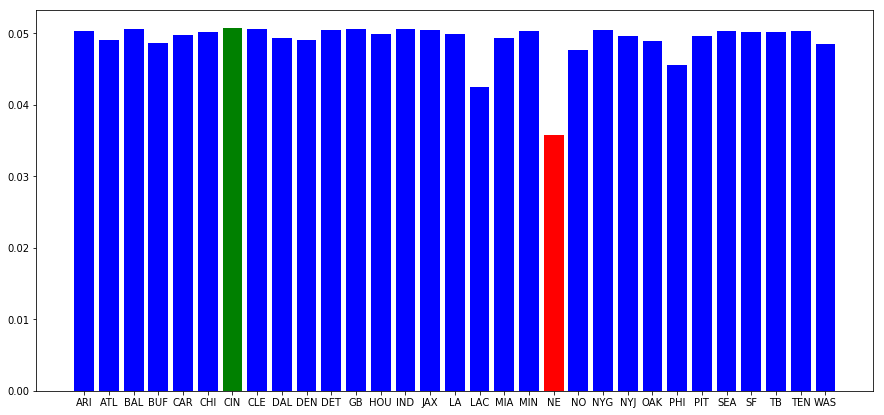

In [432]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,7))

team_names_new = np.delete(team_names,19)
KC_scores = scores[19,np.nonzero(scores[19,])[0]]

plt.bar(team_names_new,KC_scores, \
       color = ['red','blue','blue', 'blue', 'blue','blue','blue','blue', 'green', 'blue', \
                      'blue','blue','blue', 'blue', 'blue','blue','blue','blue', 'blue', 'blue', \
                      'blue','blue','blue', 'blue', 'blue','blue','blue','blue', 'blue', 'blue', \
                      'blue','blue'])
plt.show()

In [437]:
def bar_plot(scores,team_names, team):

    # plotting
    plt.figure(figsize=(16,8))

    team_names_new = np.delete(team_names,team)
    team_scores = scores[team,np.nonzero(scores[team,])[0]]
    color_plt = ["blue" for number in range(32)]
    color_plt[np.argmax(scores[team,np.nonzero(scores[team,])[0]])] = "green"
    color_plt[np.argmin(scores[team,np.nonzero(scores[team,])[0]])] = "red"
    plt.title("Page Rank Scores for %s" %team_names[team],fontsize = 20)
    plt.xlabel("Team Excluded",fontsize = 15)
    plt.ylabel("Page Rank Score",fontsize = 15)
    
    plt.bar(team_names_new,team_scores,color = color_plt)

/Users/James/Desktop/Eigth Semester/Stochastic Modelling/NFL_Project


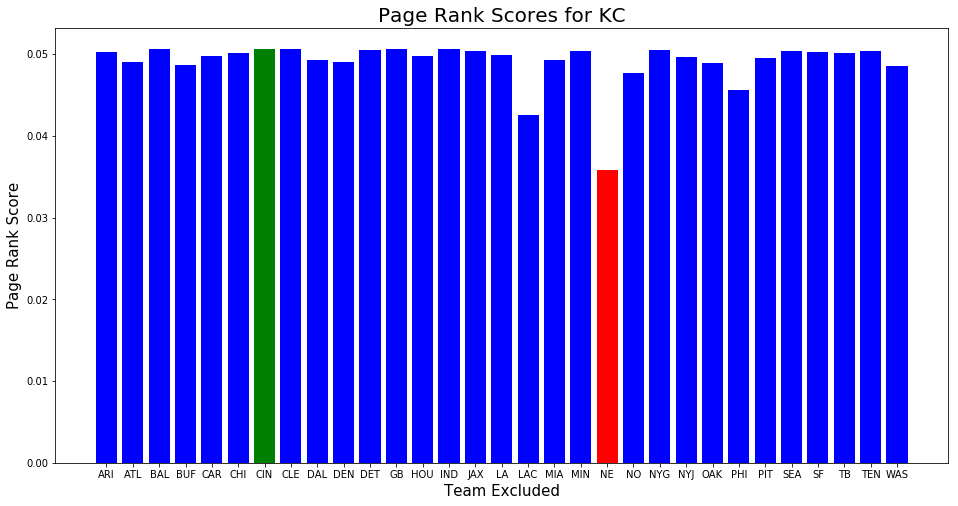

In [438]:
bar_plot(scores,team_names, 19)
%cd /Users/James/Desktop/Eigth Semester/Stochastic Modelling/NFL_Project/
plt.savefig('variance.png')

In [300]:
scores = score_bagging(Pij, stats2017, namesCols, .4, N = 2, method = 0)

In [301]:
diff_vect2 = np.zeros(32)
for iCnt in range(32):
    diff_vect2[iCnt] = np.max(scores[iCnt,np.nonzero(scores[iCnt,])[0]]) - \
                np.min(scores[iCnt,np.nonzero(scores[iCnt,])[0]])

In [302]:
print(diff_vect2)

[ 0.0429614   0.00806445  0.00614377  0.00858684  0.00392805  0.00346455
  0.          0.00678371  0.00230683  0.01256937  0.00944572  0.00421597
  0.01019     0.0377057   0.00537368  0.00706247  0.00359086  0.02011822
  0.01182669  0.02335615  0.02298902  0.0009335   0.00893357  0.00481471
  0.00722421  0.01474921  0.00478622  0.00151025  0.03706165  0.00369962
  0.00236172  0.00413588]


<Container object of 465 artists>

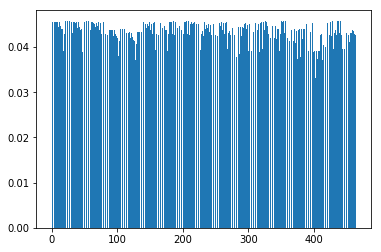

In [313]:
plt.bar(np.arange(len(scores[0,np.nonzero(scores[0,])[0]])),scores[9,np.nonzero(scores[9,])[0]])

In [304]:
np.mean(scores[1,np.nonzero(scores[1,])[0]])

0.030003512420268157

# Writing a Function to take the Score Matrix as an Input and Output the Final PageRank Vector

This function takes as inputs:

- $S$, a matrix of scores where each row is one of the 32 teams, and each column is that teams computed score when ommiting a combination of teams
- $\bar{x}$, the PageRank vector computed for each team over __full__ data set.
- $\beta$, where the PageRank for each team is computed to be $x_i = (1-\beta)\bar{x}_i + \beta\big(min\{S_{ik}, 1 \leq k \leq {32 \choose N} \text{ for } k \in Z \}\big)$ where $N$ is the number of games removed at a time from the "score_bagging" function.

This function outputs:

- $x$, the vector containing the final PageRank scores for each team.

In [365]:
def final_score(S, x_bar, beta):
    # getting the minimum vector
    min_vect = np.zeros(32)
    # computing the minimums
    for iCnt in range(len(min_vect)):
        min_vect[iCnt] =  np.min(S[iCnt,np.nonzero(S[iCnt,])[0]])
    # computing x
    x = (1-beta)*x_bar + beta*min_vect
    # normalizing x
    x = x/np.sum(x)
    # returning the value
    return x

## Comuting the Normal PageRank Scores

In [366]:
data2 = np.array(data)
Pij = data2/data2.sum(axis=0)
# making the teleporting probabilities uniform
v = np.ones(32)/32
v = v[np.newaxis]
v = v.T
# Setting alpha
alpha = 0.40
# Setting eT
eT = np.ones(32)[np.newaxis]
mat = alpha*Pij + (1-alpha)*np.dot(v,eT)
x0 = np.ones(32)/32
x0 = x0[np.newaxis]
x0 = x0.T
nSims = 100000
for i in range(nSims):
    x0 = alpha*np.dot(Pij,x0) + (1-alpha)*v
x0 = np.squeeze(x0)

In [367]:
print(x0)

[ 0.04729557  0.02928564  0.02732957  0.02803939  0.02401156  0.02511149
  0.01875     0.02949476  0.02152838  0.04322848  0.02975541  0.02457846
  0.03454632  0.04194584  0.02474222  0.03174271  0.02236897  0.04887867
  0.03855017  0.04921579  0.04796522  0.01971701  0.03596716  0.02399624
  0.03153186  0.03644147  0.03001763  0.02024483  0.04294168  0.02319317
  0.023047    0.02453733]


In [368]:
scores = score_bagging(Pij, stats2017, namesCols, .4, N = 1, method = 0)

In [369]:
beta = 1
xf = final_score(scores, x0, beta)
print(xf)

[ 0.04439473  0.02852396  0.0279545   0.0252246   0.02507082  0.02715025
  0.02223355  0.03056423  0.02419195  0.04368337  0.02839704  0.02658881
  0.03476132  0.04276085  0.02573388  0.03336079  0.02355529  0.04261436
  0.03825595  0.04109585  0.04026075  0.02261348  0.03717308  0.02571269
  0.03308511  0.02852479  0.03247584  0.02266863  0.04475371  0.02417821
  0.02590138  0.02653624]


In [370]:
team_names = np.array(data.columns.get_values())
print(team_names)

['NE' 'BUF' 'WAS' 'TEN' 'HOU' 'DET' 'CLE' 'CHI' 'CIN' 'LA' 'SF' 'GB' 'DAL'
 'MIN' 'DEN' 'BAL' 'TB' 'PIT' 'NO' 'KC' 'JAX' 'IND' 'CAR' 'OAK' 'LAC' 'SEA'
 'ATL' 'NYG' 'PHI' 'NYJ' 'ARI' 'MIA']


In [371]:
mask = np.argsort(np.squeeze(xf))[::-1]
x0_df = x0[mask]
xf_df = xf[mask]
team_names_df = team_names[mask]

In [372]:
from scipy.stats import rankdata
teamrank = {'Team': team_names_df, 'score_init': x0_df, 'score_bagged': xf_df}
teamrank_df = pd.DataFrame(data=teamrank)
teamrank_df["init_rank"] = 32 - rankdata(np.array(teamrank["score_init"]))
print(teamrank_df)

   Team  score_bagged  score_init  init_rank
0   PHI      0.044754    0.042942        5.0
1    NE      0.044395    0.047296        3.0
2    LA      0.043683    0.043228        4.0
3   MIN      0.042761    0.041946        6.0
4   PIT      0.042614    0.048879        1.0
5    KC      0.041096    0.049216        0.0
6   JAX      0.040261    0.047965        2.0
7    NO      0.038256    0.038550        7.0
8   CAR      0.037173    0.035967        9.0
9   DAL      0.034761    0.034546       10.0
10  BAL      0.033361    0.031743       11.0
11  LAC      0.033085    0.031532       12.0
12  ATL      0.032476    0.030018       13.0
13  CHI      0.030564    0.029495       15.0
14  SEA      0.028525    0.036441        8.0
15  BUF      0.028524    0.029286       16.0
16   SF      0.028397    0.029755       14.0
17  WAS      0.027954    0.027330       18.0
18  DET      0.027150    0.025111       19.0
19   GB      0.026589    0.024578       21.0
20  MIA      0.026536    0.024537       22.0
21  ARI   

In [354]:
32 - rankdata(np.array(teamrank["score_init"]))

array([  1.,   3.,   0.,   2.,   5.,   4.,   6.,   7.,   9.,  10.,   8.,
        11.,  12.,  13.,  15.,  14.,  16.,  18.,  17.,  19.,  21.,  22.,
        20.,  24.,  23.,  26.,  25.,  27.,  28.,  29.,  30.,  31.])

In [393]:
def beta_optimize_perc_combs(betas,alpha,method,filesScore,filesPercs,namesCols, N = 1, nSims = 4000,weighted = True):
    # intializing two vectors to store results
    score_perc_total = np.zeros(len(betas))
    score_perc_S2 = np.zeros(len(betas))
    wins_perc_total = np.zeros(len(betas))
    wins_perc_S2 = np.zeros(len(betas))

    indexer = 0
    
    # Generating the scores matrix for each year
    scores_mat_for_all = np.zeros((len(filesScore) - 1,32,sc.special.comb(32,N)))
    
    # iterating over all years (we lose a year since we don't have anything 
    # to regress the 2019 data on)
    for year_of_data in np.arange(len(filesScore) - 1):
            
        # reading in the data
        data = pd.read_csv(filesScore[year_of_data],index_col=0)
        stats1 = pd.read_csv(filesPercs[year_of_data],index_col=0)
        stats2 = pd.read_csv(filesPercs[year_of_data + 1],index_col=0)
        # converting to a numpy array
        data2 = np.array(data)
            
        if(weighted == False):
            data2[data2!=0] = 1
            
        # making the Pij matrix
        Pij = data2/data2.sum(axis=0)
            
        # If we want the teleportation probabilties unifrom,
        # or based on team winning perc
        if method == 0:
            # making the teleporting probabilities uniform
            v = np.ones(32)/32
            v = v[np.newaxis]
            v = v.T
            # Setting eT
            eT = np.ones(32)[np.newaxis]   
        else:
            # making the teleporting probabilities proportional to
            # the teams winning percentages
            v = np.array(stats1[namesCols[year_of_data]])
            v = v[np.newaxis]
            v = v.T
            v = v/np.sum(v)
            # Setting eT
            eT = np.ones(32)[np.newaxis]
                
        # initializing our first guess
        x0 = np.ones(32)/32
        x0 = x0[np.newaxis]
        x0 = x0.T
            
        # performing the simulation
        for i in range(nSims_use):
            x0 = alpha*np.dot(Pij,x0) + (1-alpha)*v
            
        x0 = np.squeeze(x0)
                
        # ---------------------- NEW PART OF FUNCTION (ADAPTING x0 to xf) ---------------
            
        scores_mat[year_of_data] = score_bagging(Pij, stats1, namesCols[year_of_data], \
                                       alpha, N, Nsims = nSims_use, method = method)
        
        
    # ----------------------- ITERATING OVER BETA ------------
    
    # making a waitbar
    toolbar_width = len(betas)
    sys.stdout.write("[%s]" % (" " * toolbar_width))
    sys.stdout.flush()
    sys.stdout.write("\b" * (toolbar_width+1))

    
    for beta_try in betas:
        
        if(alpha >= .8):
            nSims_use = nSims
        else:
            nSims_use = 2500
        
        # initializing the two correlations
        mc_perc_score = 0
        mc_perc_wins = 0
        
        # intializing a vector to get each percentage (for getting a standard deviation)
        sd_vect = np.zeros(len(filesScore) - 1)
        sd_vect_wins = np.zeros(len(filesScore) - 1)
        
        # iterating over all years (we lose a year since we don't have anything 
        # to regress the 2019 data on)
        for year_of_data in np.arange(len(filesScore) - 1):
            
            xf = final_score(scores_mat[year_of_data], x0, beta_try)
            
            # -------------------------------------------------------------------------------

            # defining the team names
            team_names = np.array(data.columns.get_values())
            
            # ordering the team's by their score
            mask = np.argsort(np.squeeze(xf))[::-1]
            xf_df = np.squeeze(xf[mask])
            team_names_df = team_names[mask]
            
            # forming a data frame
            teamrank = {'Team': team_names_df, 'score': xf_df, 'wins': 32*16/2*xf_df}
            teamrank_df = pd.DataFrame(data=teamrank)
            
            output = pd.merge(teamrank_df,
                  stats1,
                  left_on = "Team",
                  right_on = "team",
                  how = "inner")

            output = pd.merge(output,
                  stats2,
                  left_on = "Team",
                  right_on = "team",
                  how = "inner")
            
            # Figuring out ranks
            names = [namesCols[year_of_data],namesCols[year_of_data+1]]
            pu, ps, pw, opps = ranking_analyzer(output,names)
            
            # Storing the results
            mc_perc_score += ps
            sd_vect[year_of_data] = ps
            mc_perc_wins += pw
            sd_vect_wins[year_of_data] = pw
            
            
            
        # Updating the percentages
        score_perc_total[indexer] = mc_perc_score/(len(filesScore) - 1)
        score_perc_S2[indexer] = np.std(sd_vect)/np.sqrt(len(filesScore) - 1)
        wins_perc_total[indexer] = mc_perc_wins/(len(filesScore) - 1)
        wins_perc_S2[indexer] = np.std(sd_vect_wins)/np.sqrt(len(filesScore) - 1)
        indexer += 1
        sys.stdout.write("-")
        sys.stdout.flush()
    
        
    sys.stdout.write("\n")
    return score_perc_total,score_perc_S2,wins_perc_total,wins_perc_S2